<a href="https://colab.research.google.com/github/26112/CODEC-TECHNOLOGIES-PROJECTS-/blob/main/PROJECT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2. Weather Data Analysis and Prediction

Analyze historical weather data and predict future temperature trends.

Useful for working with time series data and basic regression techniques.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/weather-prediction")

print("Path to dataset files:", path)

100%|██████████| 936k/936k [00:00<00:00, 42.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/weather-prediction/versions/2


In [ ]:
!pip install tensorflow


LSTM input shape: (3624, 30, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0738
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0090
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0078
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0077
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0070
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0069
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0061
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0055
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0050
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0044
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


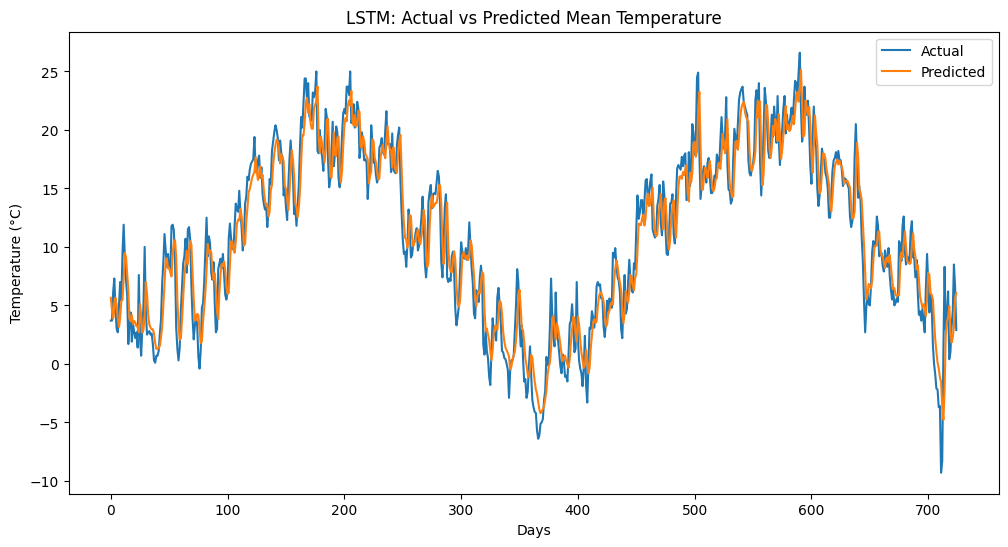

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

# Load dataset
dataset_path = "/root/.cache/kagglehub/datasets/thedevastator/weather-prediction/versions/2"
file_name = "weather_prediction_dataset.csv"
full_path = os.path.join(dataset_path, file_name)
df = pd.read_csv(full_path)

# Replace -9999 with NaN and handle missing values
df.replace(-9999, np.nan, inplace=True)

# Drop columns with too many NaNs (more than 30%) - Re-adding this step as it was in the original notebook
df = df.loc[:, df.isnull().mean() < 0.3]

# Fill remaining NaNs with column mean
df.fillna(df.mean(), inplace=True)


# Sort by time if applicable (assume daily data is already ordered)
# Need to find a target column that exists after dropping columns with many NaNs
# Based on previous errors, 'TG' was dropped. Let's use 'BASEL_temp_mean' as a proxy for mean temperature.
temperature_data = df[['BASEL_temp_mean']].values


# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temp = scaler.fit_transform(temperature_data)

# Create sequences
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_temp, seq_length)
print("LSTM input shape:", X.shape)

# Split into train/test
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict
predicted = model.predict(X_test)
predicted_temp = scaler.inverse_transform(predicted)
actual_temp = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_temp, label='Actual')
plt.plot(predicted_temp, label='Predicted')
plt.title("LSTM: Actual vs Predicted Mean Temperature")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

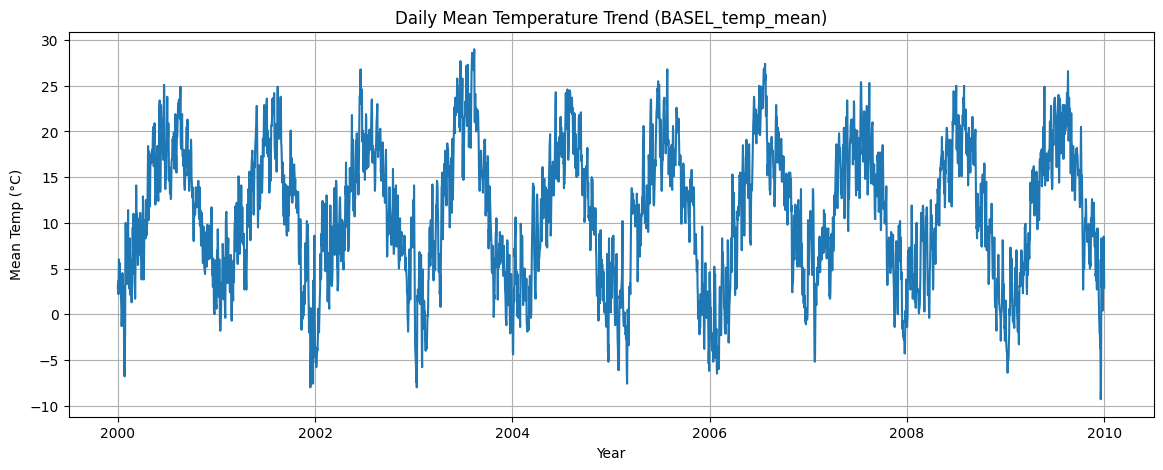

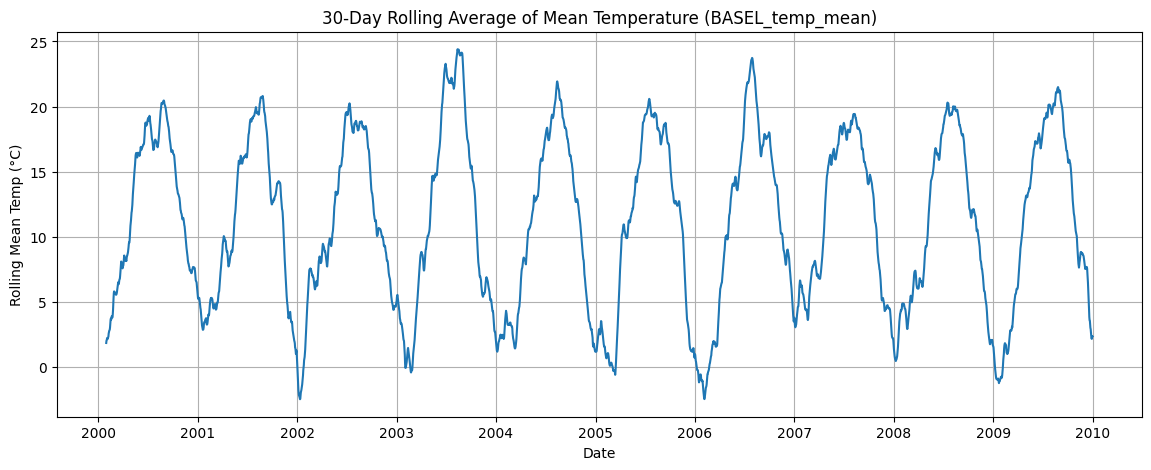

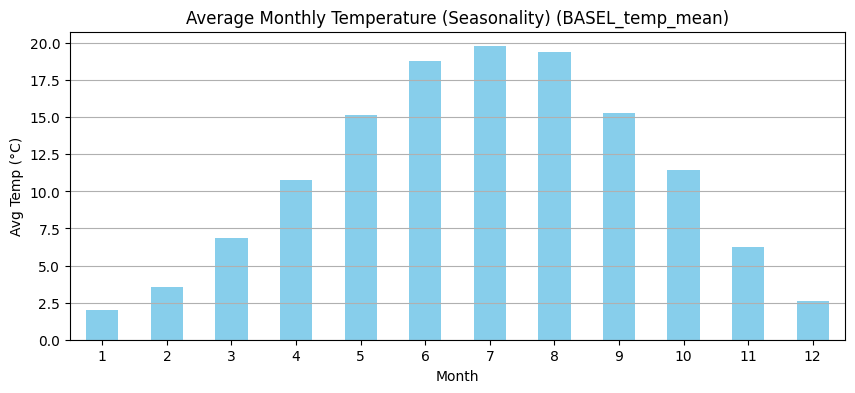

In [ ]:
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import os

# Reload & process data
dataset_path = "/root/.cache/kagglehub/datasets/thedevastator/weather-prediction/versions/2"
file_name = "weather_prediction_dataset.csv"
full_path = os.path.join(dataset_path, file_name)
df = pd.read_csv(full_path)

df.replace(-9999, np.nan, inplace=True)

# Drop columns with too many NaNs (more than 30%) - Re-adding this step as it was in the original notebook
df = df.loc[:, df.isnull().mean() < 0.3]

# Fill remaining NaNs with column mean
df.fillna(df.mean(), inplace=True)

# Assuming 'TG' column exists after cleaning based on previous analysis
# If 'TG' was dropped, need to use an alternative column like 'BASEL_temp_mean'
if 'TG' in df.columns:
    df['TG'].fillna(df['TG'].mean(), inplace=True)
    target_column = 'TG'
elif 'BASEL_temp_mean' in df.columns:
    target_column = 'BASEL_temp_mean'
else:
    raise KeyError("Neither 'TG' nor 'BASEL_temp_mean' found in the dataframe after cleaning.")


# Assume a fake date range if dates are missing
# Check if 'DATE' column exists and use it, otherwise generate a date range
if 'DATE' in df.columns:
    df['date'] = pd.to_datetime(df['DATE'], format='%Y%m%d', errors='coerce')
    # Drop rows where date conversion failed
    df.dropna(subset=['date'], inplace=True)
else:
    df['date'] = pd.date_range(start='2000-01-01', periods=len(df), freq='D')

# Plot full trend
plt.figure(figsize=(14, 5))
sns.lineplot(x='date', y=target_column, data=df)
plt.title(f'Daily Mean Temperature Trend ({target_column})')
plt.xlabel('Year')
plt.ylabel('Mean Temp (°C)')
plt.grid(True)
plt.show()

# Rolling average (30-day)
df['TG_roll'] = df[target_column].rolling(window=30).mean()
plt.figure(figsize=(14, 5))
sns.lineplot(x='date', y='TG_roll', data=df)
plt.title(f'30-Day Rolling Average of Mean Temperature ({target_column})')
plt.xlabel('Date')
plt.ylabel('Rolling Mean Temp (°C)')
plt.grid(True)
plt.show()

# Monthly average (seasonality)
df['month'] = df['date'].dt.month
monthly_avg = df.groupby('month')[target_column].mean()
plt.figure(figsize=(10, 4))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title(f'Average Monthly Temperature (Seasonality) ({target_column})')
plt.xlabel('Month')
plt.ylabel('Avg Temp (°C)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()